# CAP 5768 - Data Science - Dr. Marques - Fall 2019

Christian Garbin

## Assignment 4: Statistical analysis - Part 2
## Starter code

### Goals 

- To practice the computation and displaying of representative statistical distributions.
- To expand upon the prior experience of manipulating, summarizing, and visualizing small datasets.
- To compute moments and skewness measures.
- To increase our statistical analysis skills.
- To estimate the parameters of a distribution and propose a model that explains the underlying data.


### Instructions

- This assignment is structured in 3 parts, each one using their own dataset(s).
- As usual, there will be some Python code to be written and questions to be answered.
- At the end, you should export your notebook to PDF format; it will become your report.
- Submit the report (PDF), notebook (.ipynb file), and (optionally) link to the "live" version of your solution on Google Colaboratory via Canvas.
- The total number of points is 142 (plus up to 40 bonus points).

### Important

- It is OK to attempt the bonus points, but please **do not overdo it!** 

In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as ss

To get consistent results across runs:

In [2]:
np.random.seed(42)

In [3]:
%matplotlib inline

-------------------
## Part 1: Representative analytic distributions

In this part we will look at how to generate and plot analytic distributions.

The Python code below generates and plots the PDF and CDF of a normal (Gaussian) distribution whose parameters are *mu* and *sigma*.

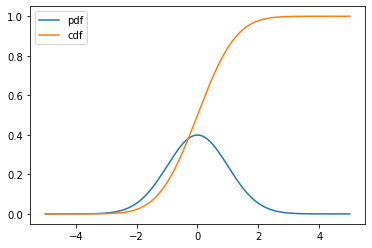

In [4]:
x = np.linspace(-5, 5, 5000)
mu = 0
sigma = 1

y_pdf = ss.norm.pdf(x, mu, sigma) # the normal pdf
y_cdf = ss.norm.cdf(x, mu, sigma) # the normal cdf

plt.plot(x, y_pdf, label='pdf')
plt.plot(x, y_cdf, label='cdf')
plt.legend();

## Your turn! (12 points, i.e., 6 pts each)

Write code to:

1. Plot the PDF of three exponential distributions (with *lambda* equal to 0.5, 1, and 2) on the same plot. 
They will probably look like this:

![PDF](notebook_images/pdf-example.png)

2. Plot the CDF of three exponential distributions (with *lambda* equal to 0.5, 1, and 2) on the same plot.
They will probably look like this:

![CDF](notebook_images/cdf-example.png)

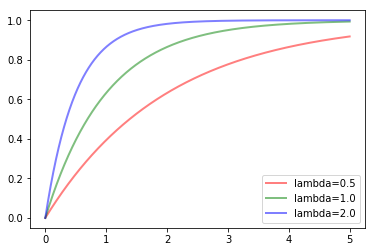
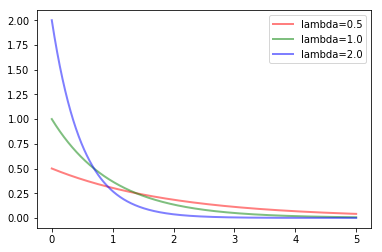

## Solution

### 1. Plot the PDF of three exponential distributions (with *lambda* equal to 0.5, 1, and 2) on the same plot.

In [5]:
lambda_to_plot = (0.5, 1.0, 2.0)
lambda_color = dict(zip(lambda_to_plot, ('r', 'g', 'b')))

In [6]:
def plot_exponential(lam, function, label, ax, ylim=(0,2), xlim=(0,5),
                     annotate=False):
    x = np.linspace(0, xlim[1], 1000)
    y_expon = function(x, 0, 1/lam)
    ax.plot(x, y_expon, label='lambda={}'.format(lam), color=lambda_color[lam],
            alpha=0.5)
    ax.set_ylabel(label)
    ax.set_xlabel('units of time')
    # Needed when using subplots
    ax.xaxis.set_tick_params(labelbottom=True)
    
    # Remove the margins so the curves "hug" the axes, making the effect of the
    # exponentials more visible (e.g. how much faster lambda=2 approaches zero)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    if annotate:
        ax.set_title('$\lambda$ = {}'.format(lam))
        
        # First, second (median), third quartiles, and 90%
        q = [np.log(4/3)/lam, np.log(2)/lam, np.log(4)/lam, -np.log(1-0.9)/lam]
        
        # Where they cross the exponential line (i.e. the value of the
        # exponential distribution at that quartile)
        yq = [lam * np.exp(-lam*x) for x in q]
        
        # Text to show where they are
        for i, t in enumerate(['1st quartile', '2nd  quartile',
                               '3rd  quartile', '90%']):
            ax.annotate('{} = {:.2f}'.format(t, q[i]),
                        xy=(q[i]+0.02, yq[i]+0.02))
        
        # Line to visualize their sizes
        for v, y in zip(q, yq):
            ax.axvline(v, 0, y/ylim[1], linestyle='--',
                       color=lambda_color[lam], alpha=0.5)
        
        # Fill the area that represents 90% of the PDF to make it easier to
        # visualize the differences between the lambdas
        ax.fill_between(x, y_expon, where=x<=q[3], color=lambda_color[lam],
                        alpha=0.25)

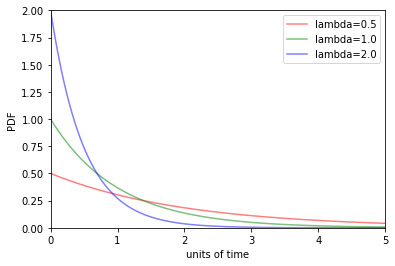

In [7]:
for lam in lambda_to_plot:
    plot_exponential(lam, ss.expon.pdf, 'PDF', plt.gca())

plt.legend()
plt.show()

$\lambda$ is the rate parameter for the exponential function. For example, when $\lambda$ is two, there are (on average) two events in each unit of time. 

Plotting the graphs separately, with annotations for the first, second (median) third quartiles and the 90% line makes the effect of $\lambda$ more visible.

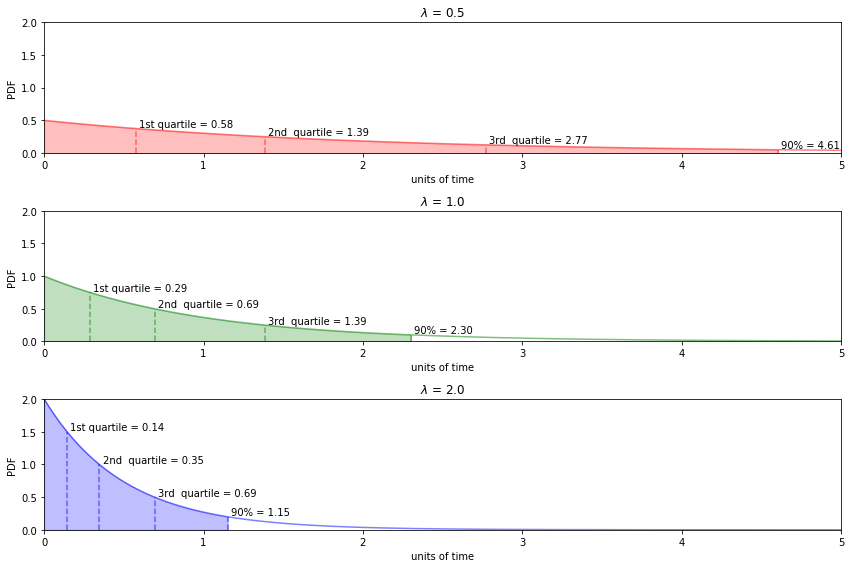

In [8]:
ax = plt.subplots(len(lambda_to_plot), 1, sharey=True, sharex=True,
                  figsize=(12, 8), tight_layout=True)
for i, lam in enumerate(lambda_to_plot):
    plot_exponential(lam, ss.expon.pdf, 'PDF', ax[1][i],
                     ylim=(0,2), xlim=(0,5), annotate=True)
plt.show()

### 2. Plot the CDF of three exponential distributions (with *lambda* equal to 0.5, 1, and 2) on the same plot.

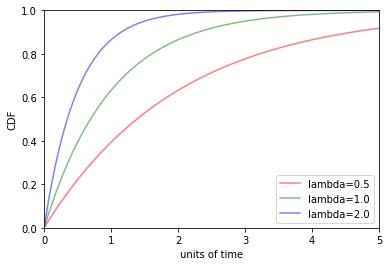

In [9]:
for lam in lambda_to_plot:
    plot_exponential(lam, ss.expon.cdf, 'CDF', plt.gca(), ylim=(0,1))

plt.legend()
plt.show()

-------------------
## Part 2: Empirical distributions vs. analytic distributions

The question we are trying to answer in this part is: **How well can we model empirical distributions with analytic distributions?**

Let's start by asking the question **Are the Belmont Stakes results normally distributed?**

*For context: Since 1926, the Belmont Stakes is a 1.5 mile-long race of 3-year old thoroughbred horses. Secretariat ran the fastest Belmont Stakes in history in 1973. While that was the fastest year, 1970 was the slowest because of unusually wet and sloppy conditions. These two outliers have been removed from the data set, which has been obtained by scraping the Belmont Wikipedia page.* (The file ``belmont.csv`` is available on Canvas, if you want to learn more about the race's results.)

The code below:
- computes mean and standard deviation of Belmont winners' times with the two outliers removed.
- takes 10,000 samples out of a normal distribution with this mean and standard deviation using
``np.random.normal()``.
- computes the CDF of the theoretical samples and the ECDF of the Belmont winners' data, assigning the results to x_theor, y_theor and x, y, respectively.
- plots the CDF of your samples with the ECDF, with labeled axes.

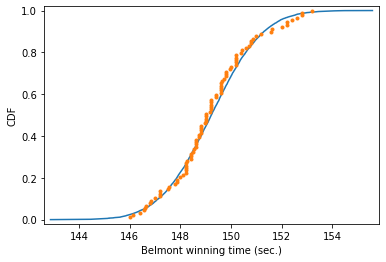

In [10]:
import numpy as np
import matplotlib.pyplot as plt

belmont_no_outliers = np.array([148.51,  146.65,  148.52,  150.7,  150.42,  150.88,  151.57,
                                147.54,  149.65,  148.74,  147.86,  148.75,  147.5,  148.26,
                                149.71,  146.56,  151.19,  147.88,  149.16,  148.82,  148.96,
                                152.02,  146.82,  149.97,  146.13,  148.1,  147.2,  146.,
                                146.4,  148.2,  149.8,  147.,  147.2,  147.8,  148.2,
                                149.,  149.8,  148.6,  146.8,  149.6,  149.,  148.2,
                                149.2,  148.,  150.4,  148.8,  147.2,  148.8,  149.6,
                                148.4,  148.4,  150.2,  148.8,  149.2,  149.2,  148.4,
                                150.2,  146.6,  149.8,  149.,  150.8,  148.6,  150.2,
                                149.,  148.6,  150.2,  148.2,  149.4,  150.8,  150.2,
                                152.2,  148.2,  149.2,  151.,  149.6,  149.6,  149.4,
                                148.6,  150.,  150.6,  149.2,  152.6,  152.8,  149.6,
                                151.6,  152.8,  153.2,  152.4,  152.2])

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

# Seed random number generator
np.random.seed(42)

# Compute mean and standard deviation: mu, sigma
mu = np.mean(belmont_no_outliers)
sigma = np.std(belmont_no_outliers)

# Sample out of a normal distribution with this mu and sigma: samples
samples = np.random.normal(mu, sigma, 10000)

# Get the CDF of the samples and of the data
x_theor, y_theor = ecdf(samples)
x, y = ecdf(belmont_no_outliers)

# Plot the CDFs and show the plot
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')
plt.margins(0.02)
_ = plt.xlabel('Belmont winning time (sec.)')
_ = plt.ylabel('CDF')
plt.show()

## Questions 1-2 (6 points, i.e., 3 pts each)

1. Does the empirical distribution of the data resemble a normal distribution? 
2. What other *plots* could you produce to better investigate (visually) the claim that the Belmont Stakes results are normally distributed? 

## Solution

### 1. Does the empirical distribution of the data resemble a normal distribution? 

Yes, for the most part. The top range of it deviates more than the other regions, but it is still fairly close to a normal distribution.

### 2. What other *plots* could you produce to better investigate (visually) the claim that the Belmont Stakes results are normally distributed? 

The simplest check is to use a histogram with a suitable number of bins.

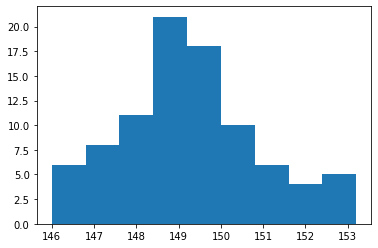

In [11]:
plt.hist(belmont_no_outliers, bins='auto')
plt.show()

A [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) plot allows us to see the an approximation of the PDF.

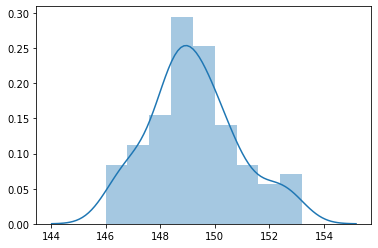

In [12]:
sns.distplot(belmont_no_outliers)
plt.show()

Both plots show an approximately gaussian distribution, skewed to the right (matching what we saw in teh ECDF, where the right side of the curve deviates from the theoretical normal distribution).

A more precise test can be done with a [probability plot](https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm). In this case, we want to check the dataset against a [normal probability plot](https://www.itl.nist.gov/div898/handbook/eda/section3/normprpl.htm).

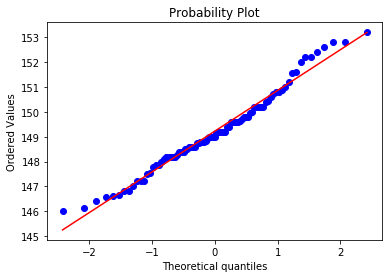

In [13]:
ss.probplot(belmont_no_outliers, plot=plt)
plt.show()

The normal probability plot shows that the distribution is normal for the most part. There are a few outliers on the left side and the right side is skewed.

If we understand, and deal with, the outliers and the right skew, a normal distribution can be used to approximate the Belmont Stakes dataset.

## BONUS (20 points)

Let's try to answer the question: **What are the chances of a horse matching or beating Secretariat's record?**

Assuming that the Belmont winners' times are Normally distributed (with the 1970
and 1973 years removed), write Python code to answer the question: *What is the probability that the winner of a given Belmont Stakes will run it as fast or faster than Secretariat?*

Instructions:
- Take 1,000,000 samples from the normal distribution using the ``np.random.normal()`` function.
- Compute the mean ``mu`` and standard deviation ``sigma`` from the ``belmont_no_outliers`` array. 
- Compute the fraction of samples that have a time less than or equal to Secretariat's time of 144 seconds.
- Print the result.

## Solution

In [14]:
# Parameters of the actual data
mu = np.mean(belmont_no_outliers)
sigma = np.std(belmont_no_outliers)

# Simulated data that follows the same parameters
samples = np.random.normal(mu, sigma, 1_000_000)

_144s_or_less = np.sum(samples <= 144)

print('Out of {:,} simulations, {} ({:.3%}) finished in 144s or less'.format(
    len(samples), _144s_or_less, _144s_or_less/len(samples)))

Out of 1,000,000 simulations, 593 (0.059%) finished in 144s or less


## Your turn (30 points)

Let's investigate whether the speed of light measurements by Michelson are normally distributed.

The dataset (``michelson_speed_of_light.csv``) is available on Canvas. 
Hint: You are only interested in the *velocity of light in air (km/s)* column.

You should follow a similar sequence of steps as above, namely:
- Compute the mean ``mu`` and standard deviation ``sigma`` from the ``michelson_speed_of_light`` array. 
- Take 10,000 samples out of a normal distribution with this mean and standard deviation using
``np.random.normal()``.
- Compute the CDF of the theoretical samples and the ECDF of the Michelson speed of light data, assigning the results to ``x_theor``, ``y_theor`` and ``x, y``, respectively.
- Plot the CDF of your samples with the ECDF, with labeled axes.

For more on Michelson: https://en.wikipedia.org/wiki/Albert_A._Michelson

## Solution

### Step 1: read the data

In [15]:
michelson = pd.read_csv('data/michelson_speed_of_light.csv')
michelson.head(3)

,Unnamed: 0,date,distinctness of image,temperature (F),position of deflected image,position of slit,displacement of image in divisions,difference between greatest and least,B,Cor,revolutions per second,radius (ft),value of one turn of screw,velocity of light in air (km/s),remarks
0,0,June 5,3,76,114.85,0.300,114.55,0.17,1.423,-0.132,257.36,28.672,0.99614,299850,Electric light.
1,1,June 7,2,72,114.64,0.074,114.56,0.10,1.533,-0.084,257.52,28.655,0.99614,299740,P.M. Frame inclined at various angles
2,2,June 7,2,72,114.58,0.074,114.50,0.08,1.533,-0.084,257.52,28.647,0.99614,299900,P.M. Frame inclined at various angles


The piece of data we are interested in.

In [16]:
michelson_velocity = michelson['velocity of light in air (km/s)']
michelson_velocity.head(3)

0    299850
1    299740
2    299900
Name: velocity of light in air (km/s), dtype: int64

### Step 2: calculate the dataset parameters

In [17]:
mu = np.mean(michelson_velocity)
sigma = np.std(michelson_velocity)
print('mu={:.0f}, sigma={:.2f}'.format(mu, sigma))

mu=299852, sigma=78.61


### Step 3: simulate a model with the empirical parameters

In [18]:
samples = np.random.normal(mu, sigma, 10_000)
print('Simulation mu={:.0f}, sigma={:.2f}'.format(
    np.mean(samples), np.std(samples)))

Simulation mu=299853, sigma=77.95


### Step 4: calculate and show ECDF and CDF

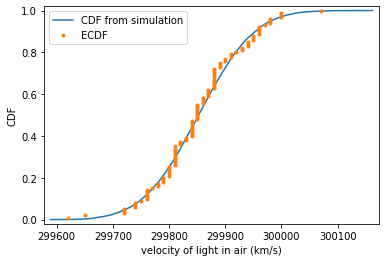

In [19]:
x_theor, y_theor = ecdf(samples)
x, y = ecdf(michelson_velocity)

plt.plot(x_theor, y_theor, label='CDF from simulation')
plt.plot(x, y, marker='.', linestyle='none', label='ECDF')

plt.xlabel('velocity of light in air (km/s)')
plt.ylabel('CDF')
plt.legend()
plt.margins(0.02)
plt.show()

## Questions 3-4 (6 points, i.e., 3 pts each)

3. Does the empirical distribution of the data resemble a normal distribution? 
4. What other *plots* could you produce to better investigate (visually) the claim that the Michelson speed of light measurements are normally distributed? 

## Solution

### 3. Does the empirical distribution of the data resemble a normal distribution? 

It resembles a normal distribution for the most part. There are a few outliers to the left and to the right, but most of the samples fall reasonably close to a normal distribution.

### 4. What other *plots* could you produce to better investigate (visually) the claim that the Michelson speed of light measurements are normally distributed? 

A [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) plot, to see the approximate PDF of the dataset.

The plot below shows the dataset in blue and the sample (simulated) dataset in orange.

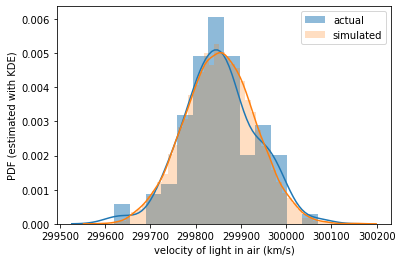

In [20]:
sns.distplot(michelson_velocity, label='actual', hist_kws={'alpha': 0.5})
sns.distplot(samples, label='simulated', hist_kws={'alpha': 0.25})
plt.ylabel('PDF (estimated with KDE)')
plt.legend()
plt.show()

The KDE plot shows that the velocity looks normally distributed, with a small left skew and a few outliers.

We can see more deatails with a [normal probability plot](https://www.itl.nist.gov/div898/handbook/eda/section3/normprpl.htm).

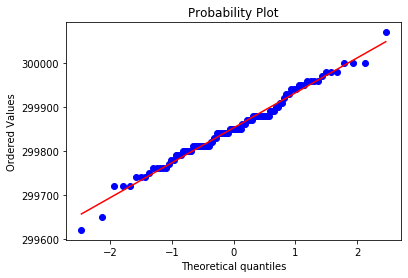

In [21]:
ss.probplot(michelson_velocity, plot=plt)
plt.show()

The normal probability plot shows that there are a few ouliers to the left and right that need to be examined, but in general the measurements follow a normal distribution.

## Your turn (30 points)

Next, let's turn our attention to baby births.

In the real world, exponential distributions come up when we look at a series of events and measure the times between events, called *interarrival times*. If the events are equally likely to occur at any time, the distribution of interarrival times tends to look like an exponential distribution.

We will use the dataset from ``babies_brisbane.csv`` containing information about the time of birth for  44 babies born in a hospital in Brisbane, Australia, on December 18, 1997, as reported in the local paper. 

You should write code to:
1. Read the data and build a Pandas dataframe.
2. Compute the reciprocal of the mean of the sample exponential distribution (call this ``lam``, since ``lambda`` is a reserved word in Python).
3. Take 10,000 samples out of an exponential distribution with this scale using
``np.random.exponential()``.
4. Compute the CDF of the theoretical samples and the ECDF of the sample data, assigning the results to ``x_theor``, ``y_theor`` and ``x, y``, respectively.
5. Plot the CDF of your samples with the ECDF, with labeled axes.
6. Compute the Complementary CDF (CCDF) and plot the CCDF for both theoretical and sample values, on a log-y scale. (See Figure 5-2 in the textbook)

## Solution

### Step 1: read the data

In [22]:
babies = pd.read_csv('data/babies_brisbane.csv')
babies.head(5)

,Unnamed: 0,time,sex,weight_g,minutes
0,0,5,1,3837,5
1,1,104,1,3334,64
2,2,118,2,3554,78
3,3,155,2,3838,115
4,4,257,2,3625,177


We are interested in interarrival time, i.e. the time between one event (one birth) and the next.

In [23]:
births_interarrival = babies.minutes.diff()
# There is no "interarrival" for the first element in the series
births_interarrival.head(5)

0     NaN
1    59.0
2    14.0
3    37.0
4    62.0
Name: minutes, dtype: float64

### Step 2: calculate the dataset parameters

_Lambda_ describes the exponential distribution. It is the reciprocal of the mean.

In [24]:
lam = 1 / np.mean(births_interarrival)
print('Dataset lambda={:.5f}, mean={:.2f}'.format(
    lam, np.mean(births_interarrival)))

Dataset lambda=0.03007, mean=33.26


Interpretation: _lambda_ can be interpreted as the rate of events, i.e. the number of events that occur in a unit of time. In this case, it implies 0.03 babies are born every minute (on average), or one baby every 33 minutes (on average).

### Step 3: simulate a model with the empirical parameters

In [25]:
samples = np.random.exponential(1/lam, 10_000)
print('Simulated sample lambda={:.5f}, mean={:.2f}'.format(
    1/np.mean(samples), np.mean(samples)))

Simulated sample lambda=0.03042, mean=32.87


### Step 4: calculate and show ECDF and CDF

In [26]:
x_theor, y_theor = ecdf(samples)
x, y = ecdf(births_interarrival)

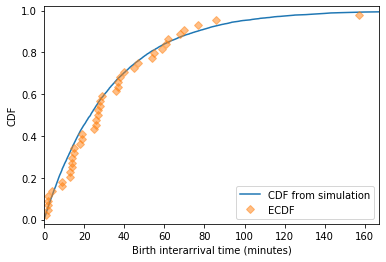

In [27]:
plt.plot(x_theor, y_theor, label='CDF from simulation')
plt.plot(x, y, marker='D', linestyle='none', label='ECDF', alpha=0.5)

# Limit the plot within the range of the empirical data, otherwise
# the simulated data would extend it far to the right, losing
# resolution for the empirical data
plt.xlim((0, np.max(births_interarrival) + 10))

plt.xlabel('Birth interarrival time (minutes)')
plt.ylabel('CDF')
plt.legend()
plt.margins(0.02)
plt.show()

### Step 5: calculate and show the complementary CDF (CCDF)

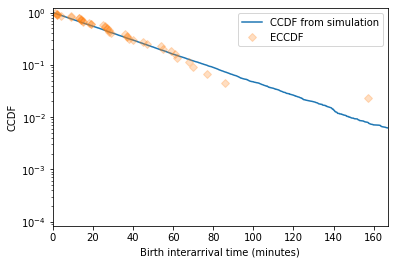

In [28]:
plt.plot(x_theor, 1-y_theor, label='CCDF from simulation')
# Use smaller alpha to see where we have overlaps more clearly
plt.plot(x, 1-y, marker='D', linestyle='none', label='ECCDF', alpha=0.25)

plt.yscale('log')

# Limit the plot within the range of the empirical data, otherwise
# the simulated data would extend it far to the right, losing
# resolution for the empirical data
plt.xlim((0, np.max(births_interarrival) + 10))

plt.xlabel('Birth interarrival time (minutes)')
plt.ylabel('CCDF')
plt.legend()
plt.margins(0.02)
plt.show()

The complementary CDF of an exponential distribution should be a straight line when plotted in a log scale. The graph shows that the empirical distribution diverges from theoretical line towards the right (larger interarrival times). There is also a cluster of short interarrival times (the darker yellow patches toward the left). 

These two observations result in the exponential distribution not being a good model for the data (the fact that it is a small sample does not help either). Another distribution may be better suited for this data if modeling precision is important.

-------------------
## Part 3: Moments and skewness

Let's revisit the dataset of salaries from Assignment 1 and use it to measure skewness.

In [29]:
salaries = pd.read_csv('data/salaries.csv')
salaries.head(5)

,earn,height,sex,ed,age,race
0,50000.0,74.424439,male,16,45,white
1,60000.0,65.537543,female,16,58,white
2,30000.0,63.629198,female,16,29,white
3,50000.0,63.108562,female,16,91,other
4,51000.0,63.402484,female,17,39,white


# Your turn (32 points, i.e., 8 pts each)

Write Python code to:
1. Compute the median and mean salary for the entire sample.
2. Compute the first raw moment and show that it is equivalent to computing the mean value.
3. Compute the second central moment and show that it is equivalent to computing the variance.
4. Compute the skewness using ``scipy.stats.skew``

## Solution

### 1. Compute the median and mean salary for the entire sample.

In [30]:
earn = salaries['earn']

In [31]:
def print_median_mean(data):
    print('The median salary is ${:,.2f}, the mean salary is ${:,.2f}'.format(
        np.median(data), np.mean(data)))

print_median_mean(earn)

The median salary is $20,000.00, the mean salary is $23,154.77


### 2. Compute the first raw moment and show that it is equivalent to computing the mean value.

In [32]:
def raw_moment(data, k):
    '''Calculate the kth raw moment.'''
    return sum(x**k for x in data) / len(data)

def print_first_raw_moment(data):
    moment = raw_moment(data, 1)
    mean = np.mean(data)

    print('First moment: {:.2f}'.format(moment))
    print('Mean: {:>16.2f}'.format(mean))

    # Note use of `allclose` because different sequence of operations on the
    # same set of float numbers may result in slightly different numbers
    print('First moment == mean: {}'.format(np.allclose(moment, mean)))
    
print_first_raw_moment(earn)

First moment: 23154.77
Mean:         23154.77
First moment == mean: True


### 3. Compute the second central moment and show that it is equivalent to computing the variance.

In [33]:
def central_moment(data, k):
    '''Calculate the kth central moment.'''
    mean = np.mean(data)
    return sum((x - mean)**k for x in data) / len(data)

def print_second_central_moment(data):
    moment = central_moment(data, 2)
    var = np.var(data)

    print('Second central moment: {:.2f}'.format(moment))
    print('Variance: {:>25.2f}'.format(var))

    # Note use of `allclose` because different sequence of operations on the
    # same set of float numbers may result in slightly different numbers
    print('Second central moment == variance: {}'.format(np.allclose(moment, var)))

print_second_central_moment(earn)

Second central moment: 378852251.62
Variance:              378852251.62
Second central moment == variance: True


### 4. Compute the skewness using `scipy.stats.skew`

In [34]:
def print_skewness(data):
    skewness = ss.skew(data)
    print(skewness)

print_skewness(earn)

2.880309741267592


## Question 5 (6 points)

5. How do you interpret the value of skewness computed by your code?

## Solution

A positive skewness value indicates a distribution that is skewed to the right. Conversely, a negative skewness indicates a left-skewed distribution.

The value calculated above is positive. That means the salary distribution is right skewed, i.e. the median is to the left of the mean.

Moreover, the calculated value indicates the distribution is [highly skewed](https://brownmath.com/stat/shape.htm#SkewnessInterpret).

The skew is visible in the distribution plot below.

The distribution skewness = 2.88
The distribution is right skewed


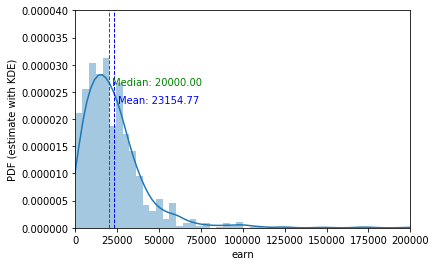

In [35]:
def analyze_skewness(data):    
    skewness = ss.skew(data)
    print('The distribution skewness = {:.2f}'.format(skewness))
    if np.allclose(skewness, 0):
        print('The distribution is not skewed')
    else:
        print('The distribution is {} skewed'.format(
        'right' if skewness > 0 else 'left'))

def plot_skewness(data):
    ax = sns.distplot(data);

    # Plot annotations from
    # https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
    median = np.median(data)
    mean = np.mean(data)

    ax.axvline(median, color='g', linestyle='dashed', linewidth=1)
    ax.axvline(mean, color='b', linestyle='dashed', linewidth=1)

    _, max_ylim = plt.ylim()
    ax.text(median*1.1, max_ylim*0.8,
            'Median: {:.2f}'.format(median), color='g')
    ax.text(mean*1.1, max_ylim*0.7,
            'Mean: {:.2f}'.format(mean), color='b');

    # Plot on the same scale so we can compare graphs of different subsets
    # (e.g. female and male)
    # These are empirical values - should be derived from the dataset
    # in production code
    plt.xlim(0, np.max(salaries['earn']))
    plt.ylim(0, 0.00004)

    plt.ylabel('PDF (estimate with KDE)')
    plt.show()

analyze_skewness(earn)
plot_skewness(earn)

More examples of skewness, showing their shape and how the mean and median move apart as skewness increases.

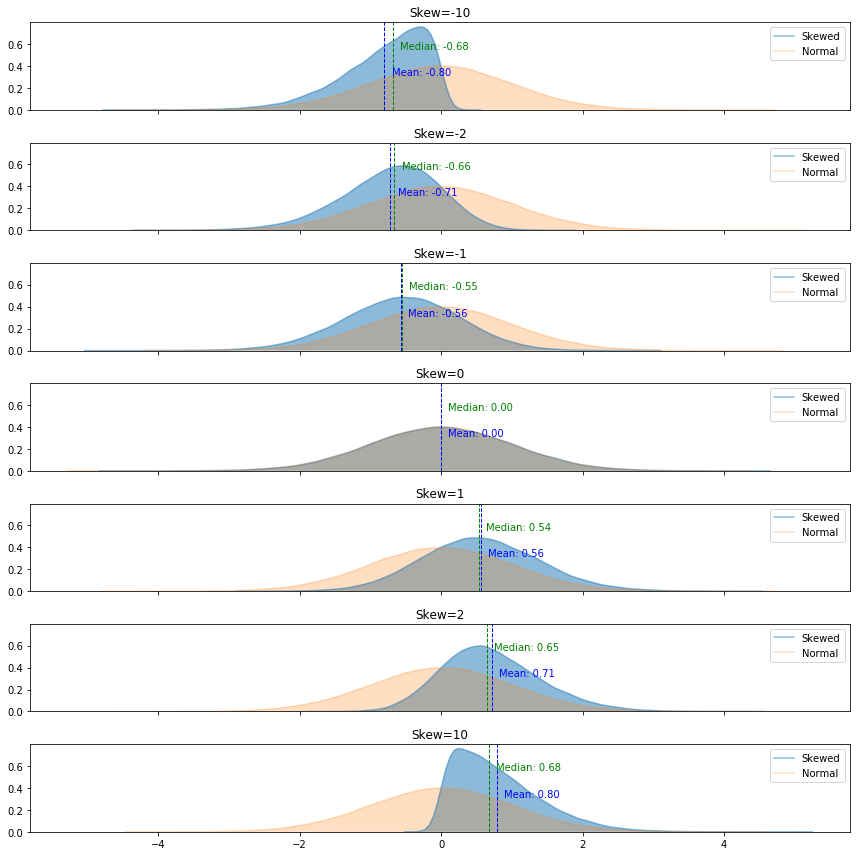

In [36]:
def plot_skewed_distribution(skew, ax):
    # Use a large size to create a smooth PDF
    dist = ss.skewnorm.rvs(skew, size=100_000)
    # The normal distribution could be calculated once, outside of the function
    # Done here for simplicity
    normal = ss.skewnorm.rvs(0, size=100_000)
    sns.distplot(dist, ax=ax, hist=False,
                 kde_kws={'shade': True, 'alpha': 0.5}, label='Skewed')
    sns.distplot(normal, ax=ax, hist=False,
                 kde_kws={'shade': True, 'alpha': 0.25}, label='Normal')
    ax.title.set_text('Skew={}'.format(skew))

    # A little bit of cheating: if skew = 0, don't calculate from the sample
    # data because it may not result in exactly zero (it's sample, not
    # theoretical data)
    median = np.median(dist) if skew != 0 else 0
    mean = np.mean(dist) if skew != 0 else 0

    ax.axvline(median, color='g', linestyle='dashed', linewidth=1)
    ax.axvline(mean, color='b', linestyle='dashed', linewidth=1)

    _, max_ylim = plt.ylim()
    ax.text(median+0.1, max_ylim*0.7,
            'Median: {:.2f}'.format(median), color='g')
    ax.text(mean+0.1, max_ylim*0.4,
            'Mean: {:.2f}'.format(mean), color='b')

skews = (-10, -2, -1, 0, 1, 2, 10)
ax = plt.subplots(len(skews), 1, sharey=True, sharex=True, figsize=(12, 12),
                  tight_layout=True)

for i, skew in enumerate(skews):
    plot_skewed_distribution(skew, ax[1][i])
plt.show()

## Bonus! (20 points)

Write code to repeat the steps above, this time for male and female employees separately.

## Solution



Analyzing female salaries
The median salary is $15,000.00, the mean salary is $18,280.20
First moment: 18280.20
Mean:         18280.20
First moment == mean: True
Second central moment: 203049680.63
Variance:              203049680.63
Second central moment == variance: True
The distribution skewness = 2.23
The distribution is right skewed


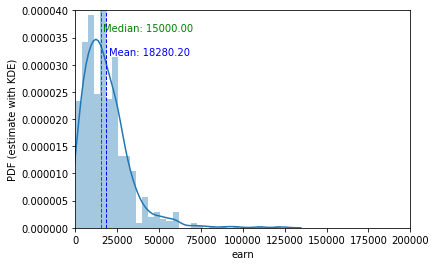



Analyzing male salaries
The median salary is $25,000.00, the mean salary is $29,786.13
First moment: 29786.13
Mean:         29786.13
First moment == mean: True
Second central moment: 541713403.76
Variance:              541713403.76
Second central moment == variance: True
The distribution skewness = 2.73
The distribution is right skewed


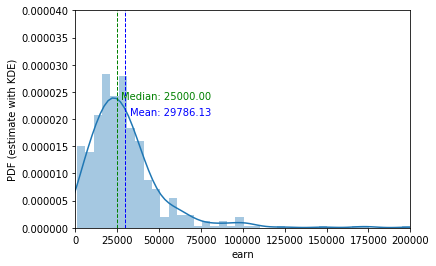

In [37]:
for genre in ('female', 'male'):
    data = salaries[salaries.sex == genre]['earn']
    print('\n\nAnalyzing {} salaries'.format(genre))
    
    print_median_mean(data)
    print_first_raw_moment(data)
    print_second_central_moment(data)
    analyze_skewness(data)
    plot_skewness(data)

## Conclusions (20 points)

Write your conclusions and make sure to address the issues below:
- What have you learned from this assignment?
- Which parts were the most fun, time-consuming, enlightening, tedious?
- What would you do if you had an additional week to work on this?

## Solution

### What have you learned from this assignment?

1. How to quantify skewness and what it represents for the data (how median and mean are affected by it).
1. Removed from my had the concept that "skewness == bad" - it's just what the sample data is; it may or may not be bad.
1. "Modeling" as "data compression", reducing a (potentially) large dataset to a few parameters.
1. How to validate a model by generating sample data.
1. The exponential distribution and how it is used to model interarrival time.

### Which parts were the most fun, time-consuming, enlightening, tedious?

**Fun**

1. Model data: calculate the parameters, generate theoretical data, plot and check.

**Time-consuming**

1. Tweaking graphs: add annotations, adjust scales, etc. (but mainly because I chose to do so and don't know much about those areas of Matplotlib yet).
1. Understand the [location-scale](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) (and [this page](https://www.itl.nist.gov/div898/handbook/eda/section3/eda364.htm)) concept when trying to use SciPy APIs.
1. Understand how to interpret the exponential distribution. [This article](https://towardsdatascience.com/what-is-exponential-distribution-7bdd08590e2a) helped, especially the pointer to the [companion article on Poisson distribution](https://medium.com/@aerinykim/poisson-distribution-intuition-and-derivation-1059aeab90d). Once I established the link between the two, it was easier to understand it. In general, I found the explanations in the textbook (chapter 5) too terse for my level of knowledge in statistics. More generally, spending more time in an intuitional approach first would have helped someone with my level of knowledge.

**Enlightening**

1. How simple and visually powerful it is to check a model against the real data with a graph, once we know how to generate a simulation with the correct model parameters.

**Tediuos**

1. None

### What would you do if you had an additional week to work on this?

1. Study other distributions functions and what type of real-world problems they model. I would be especially interested in Poisson and Exponential distributions for event modeling, a topic close to my work.
1. Understand the theoretical aspects of the most commonly used distributions, also considering the concept of "location-scale" and they affect the distributions.
1. Work on a time series problem from beginning to end (EDA, modeling, making and verifying predictions).